In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import matplotlib.pyplot as plt
tqdm.pandas()

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:38, 5185.62it/s]



Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Анализ текстов

In [4]:
data = pd.DataFrame(responses)

data.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


### Кол-во отзывов в разных городах и банках

In [5]:
import string
import re

In [6]:
punctuation_chars = string.punctuation.replace("-", "")

def prepare_city(city: str):
    if isinstance(city, str) and len(city):
        try:
            city_name = city.split(".")[1].strip()
        except:
            city_name = city

        for punc in punctuation_chars:
            city_name = city_name.replace(punc, "")
        
        if len(city_name) > 1:
            city_name = city_name[0].upper() + city_name[1:]
        return city_name
    else:
        return city

In [7]:
print("Кол-во городов до обработки: ", len(data["city"].unique()))

data["city"] = data["city"].apply(prepare_city)

print("Кол-во городов после обработки: ", len(data["city"].unique()))

Кол-во городов до обработки:  5824
Кол-во городов после обработки:  4611


In [9]:
data.groupby("city")["text"].count().sort_values(ascending=False)

city
Москва                           56597
Санкт-Петербург                  14352
Новосибирск                       2374
Екатеринбург                      2364
Нижний Новгород                   1978
                                 ...  
Москва Углич                         1
Москва Ульяновск                     1
Москва Фрунзенский филиал            1
Москва Фрязино                       1
… или другой населенный пункт        1
Name: text, Length: 4610, dtype: int64

In [10]:
data.groupby("bank_name")["text"].count().sort_values(ascending=False)

bank_name
Сбербанк России           26327
Альфа-Банк                10224
ВТБ 24                     8185
Русский Стандарт           7943
Хоум Кредит Банк           7549
                          ...  
Северный Народный Банк        1
Сельмашбанк                   1
Сиббизнесбанк                 1
Сибконтакт                    1
Мигом                         1
Name: text, Length: 670, dtype: int64

### Гистограмма кол-ва слов и символов

In [11]:
punctuation_chars

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [8]:
from collections import defaultdict

char_counter = defaultdict(int)

punctuation_chars +="-"

def get_words(text: str):
    for punc in punctuation_chars:
        text = text.replace(punc, "")
    
    text = text.strip()

    words = text.split()

    words = [word.lower() for word in words]

    return words

for text in tqdm(data["text"]):
    words = get_words(text)
    
    for word in words:
        char_counter[len(word)] +=1

  0%|          | 0/153499 [00:00<?, ?it/s]

100%|██████████| 153499/153499 [00:09<00:00, 15774.22it/s]


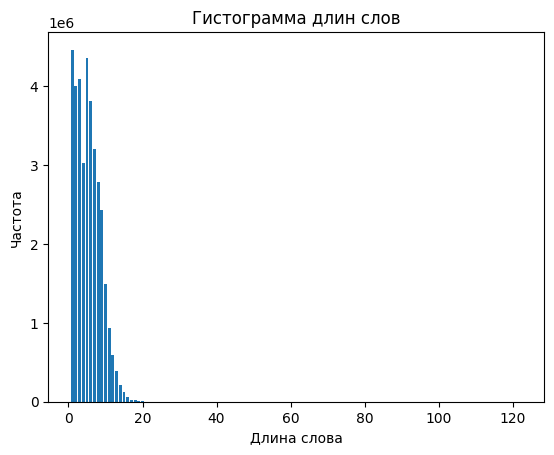

In [9]:
labels = list(char_counter.keys())[:40] # Не будем брать для визуализации очень длинные слова (вероятно - выбросы)
values = list(char_counter.values())[:40]

# Создаем гистограмму
plt.bar(labels, values)
plt.xlabel('Длина слова')
plt.ylabel('Частота')
plt.title('Гистограмма длин слов')
plt.show()

In [10]:
word_counter = defaultdict(int)

for text in tqdm(data["text"]):
    sentences = nltk.sent_tokenize(text)

    for sentence in sentences:
        words = get_words(sentence)
        word_counter[len(words)] +=1

100%|██████████| 153499/153499 [00:42<00:00, 3608.42it/s]


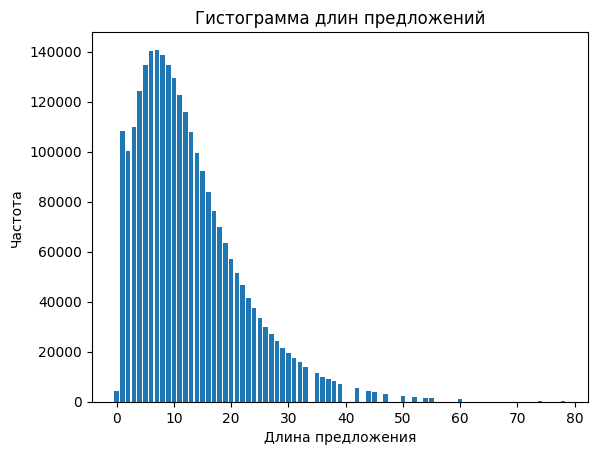

In [11]:
labels = list(word_counter.keys())[:50] # Не будем брать для визуализации очень длинные предложения (вероятно - выбросы)
values = list(word_counter.values())[:50]

# Создаем гистограмму
plt.bar(labels, values)
plt.xlabel('Длина предложения')
plt.ylabel('Частота')
plt.title('Гистограмма длин предложений')
plt.show()

### 10 самых частых слов

#### Из всех слов

In [15]:
all_words = []

for text in data["text"]:
    words = get_words(text)
    all_words +=words
    
allWordsDict = nltk.FreqDist(all_words)

for word, frequency in allWordsDict.most_common(10):
    print(f"{word}: {frequency}")

в: 1322256
и: 1054334
не: 850953
на: 703924
что: 620562
я: 574839
с: 454775
по: 364872
мне: 320547
банка: 263213


#### Без стоп слов

In [12]:
from nltk.corpus import stopwords


russian_stopwords = stopwords.words("russian")

In [16]:
all_words = [word for word in all_words if word not in russian_stopwords]
    
allWordsDict = nltk.FreqDist(all_words)

for word, frequency in allWordsDict.most_common(10):
    print(f"{word}: {frequency}")

банка: 263213
банк: 193355
это: 182764
деньги: 129708
карту: 104711
карты: 100582
кредит: 79595
день: 75850
заявление: 69315
отделение: 66338


#### Леммы

In [13]:
import pymorphy3


morph = pymorphy3.MorphAnalyzer()

In [17]:
# Лемматизация слов
lemmas = [morph.parse(word)[0].normal_form for word in tqdm(all_words)]

allWordsDict = nltk.FreqDist(lemmas)

for word, frequency in allWordsDict.most_common(10):
    print(f"{word}: {frequency}")


100%|██████████| 23313378/23313378 [18:39<00:00, 20828.09it/s]


банк: 620194
карта: 330817
это: 199441
деньга: 177871
день: 172158
мой: 166915
кредит: 153905
который: 148831
отделение: 143384
счёт: 140126


#### Существительные

In [ ]:
# Фильтрация существительных
nouns = []
for lemma in tqdm(lemmas):
    parsed_word = morph.parse(lemma)
    for p in parsed_word:
        if 'NOUN' in p.tag:
            nouns.append(p.normal_form)
            break  

allNounsDict = nltk.FreqDist(nouns)

for word, frequency in allNounsDict.most_common(10):
    print(f"{word}: {frequency}")

100%|██████████| 24358541/24358541 [19:59<00:00, 20308.17it/s]


банк: 395680
карта: 219719
деньга: 128634
отделение: 109285
сотрудник: 109248
счёт: 95008
кредит: 94558
день: 93745
сумма: 86175
клиент: 81409


Слово "сотрудник" встречается в текстах чаще, чем слово "клиент"

In [ ]:
print(f"Частота слова 'мошенничество': {allWordsDict['мошенничество']}")
print(f"Частота слова 'доверие': {allWordsDict['доверие']}")

Частота слова 'мошенничество': 1429
Частота слова 'доверие': 1440


### Закон Ципфа

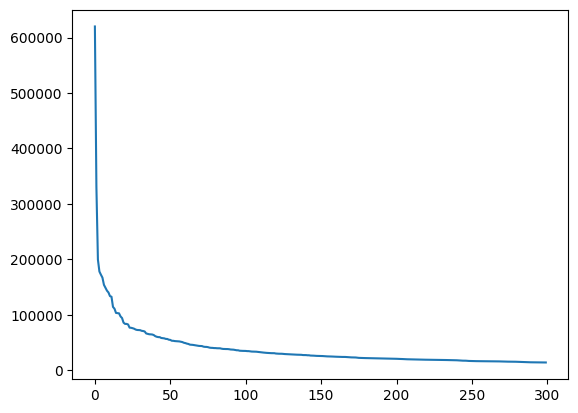

In [22]:
freqs = list(allWordsDict.values())
freqs = sorted(freqs, reverse=True)

fig, ax = plt.subplots()
ax.plot(range(300), freqs[:300])
plt.show()

### Закон Хипса

100%|██████████| 153499/153499 [02:37<00:00, 975.01it/s] 


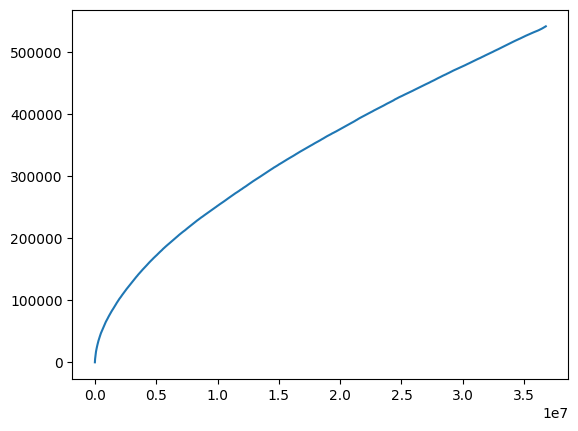

In [ ]:
from collections import Counter


cnt = Counter()
n_words = []
n_tokens = []
tokens = []
total_tokens = 0 

for index, row in tqdm(data.iterrows(), total=len(data)):
  tokens = nltk.tokenize.word_tokenize(row["text"])
  tokens_to_add = [token for token in tokens if token not in punctuation_chars]
  total_tokens += len(tokens_to_add)
  cnt.update(tokens_to_add)
  n_words.append(len(cnt))
  n_tokens.append(total_tokens)

plt.plot(n_tokens, n_words)
plt.show()

### Ключевые слова и биграммы

In [27]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer


def prepare_text(text):
    prepared_sentences = ""
    sentences = nltk.sent_tokenize(text)
    for sentence in sentences:
        all_words = get_words(sentence)

        all_words = [word for word in all_words if word not in russian_stopwords]

        # Лемматизация слов
        lemmas = [morph.parse(word)[0].normal_form for word in all_words]
        prepared_sentences += " ".join(lemmas) + ". "

    return prepared_sentences
        

In [28]:
positive_reviews = data[data["rating_grade"] == 5].copy()

positive_reviews["cleaned_text"] = positive_reviews["text"].progress_apply(prepare_text)

100%|██████████| 14713/14713 [01:50<00:00, 132.58it/s]


In [35]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Применяем TF-IDF к документу
tfidf_positive = vectorizer.fit_transform(positive_reviews["cleaned_text"].tolist())

positive_keywords = vectorizer.get_feature_names_out()
positive_scores = tfidf_positive.sum(axis=0).A1

positive_df = pd.DataFrame({'keyword': positive_keywords, 'score': positive_scores})

positive_df = positive_df.sort_values(by="score", ascending=False)

print("Положительные ключевые слова и биграмы:")
print(positive_df.head(10))

Положительные ключевые слова и биграмы:
          keyword       score
62767        банк  544.223923
312425      карта  344.545953
114919      вклад  243.369590
350169     кредит  234.780383
546864      очень  221.446252
520562  отделение  213.366149
951667        это  207.673455
195982       день  191.639031
810787  сотрудник  185.937154
325387     клиент  185.260812


In [29]:
negative_reviews = data[data["rating_grade"] == 1].copy()

negative_reviews["cleaned_text"] = negative_reviews["text"].progress_apply(prepare_text)

100%|██████████| 47387/47387 [06:48<00:00, 116.08it/s]


In [33]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Применяем TF-IDF к документу
tfidf_negative = vectorizer.fit_transform(negative_reviews["cleaned_text"].tolist())

negative_keywords = vectorizer.get_feature_names_out()
negative_scores = tfidf_negative.sum(axis=0).A1

negative_df = pd.DataFrame({'keyword': negative_keywords, 'score': negative_scores})

negative_df = negative_df.sort_values(by="score", ascending=False)

print("Отрицательные ключевые слова и биграмы:")
print(negative_df.head(10))

Отрицательные ключевые слова и биграмы:
           keyword        score
287405        банк  1650.279462
947803       карта  1345.012755
632670      деньга   848.448111
1039642     кредит   750.830947
1487332  отделение   717.242105
625979        день   706.492287
2618222        это   691.559125
2349904       счёт   686.117853
1156649        мой   649.350538
2247766  сотрудник   623.764328


## Тематическое моделирование

In [12]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [18]:
def get_tokens(text: str):
    text = prepare_text(text)
    text = nltk.tokenize.word_tokenize(text, language="russian")
    tokens = [token for token in text if token not in punctuation_chars]
    return tokens

def get_bigrams(text: str):
    text = prepare_text(text)
    tokens = nltk.tokenize.word_tokenize(text)
    bigram = Phrases(tokens, min_count=1, threshold=2)
    bigram_phraser = Phraser(bigram)
    return bigram_phraser[tokens]

In [19]:
texts = [get_bigrams(text) for text in tqdm(data["text"])]

100%|██████████| 153499/153499 [21:53<00:00, 116.91it/s]


In [20]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [21]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
from gensim.models import lsi

In [23]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=20)

CPU times: total: 1min 14s
Wall time: 1min 6s


In [24]:
lsi.show_topics()

[(0,
  '0.187*"карта" + 0.131*"кредит" + 0.111*"деньга" + 0.104*"счёт" + 0.103*"вклад" + 0.102*"заявление" + 0.098*"отделение" + 0.097*"банкомат" + 0.089*"сумма" + 0.088*"сотрудник"'),
 (1,
  '-0.556*"вклад" + 0.284*"кредит" + -0.146*"очередь" + 0.142*"платёж" + 0.136*"задолженность" + -0.133*"открыть" + 0.120*"страховка" + 0.113*"погашение" + 0.107*"звонок" + 0.101*"кредитный"'),
 (2,
  '-0.343*"банкомат" + 0.329*"вклад" + -0.295*"карта" + 0.257*"кредит" + -0.176*"сбербанк" + 0.153*"договор" + -0.153*"деньга" + 0.145*"страховка" + -0.137*"операция" + -0.119*"средство"'),
 (3,
  '0.246*"вклад" + 0.208*"сумма" + -0.179*"номер" + 0.162*"руб" + -0.156*"заявка" + 0.151*"договор" + 0.149*"погашение" + 0.149*"платёж" + 0.149*"рубль" + 0.143*"000"'),
 (4,
  '0.387*"«" + 0.383*"»" + -0.175*"кредит" + 0.174*"номер" + -0.167*"страховка" + 0.166*"вклад" + -0.165*"банкомат" + -0.143*"заявка" + 0.130*"–" + 0.118*"звонок"'),
 (5,
  '0.405*"карта" + -0.302*"банкомат" + 0.191*"«" + 0.189*"»" + 0.173*"

In [25]:
X = [0] * len(data)
Y = [0] * len(data)
for i in range(len(data)):
    vec = corpus[i]
    LSI_topics = (lsi[vec])
    for topic in LSI_topics:
        if topic[0] == 0:
            X[i] = topic[1]
        elif topic[0] == 1:
            Y[i] = topic[1]

vis_df = pd.DataFrame({'X': X, 'Y': Y, 'rating_grade' : data["rating_grade"]})

<Figure size 1400x1400 with 0 Axes>

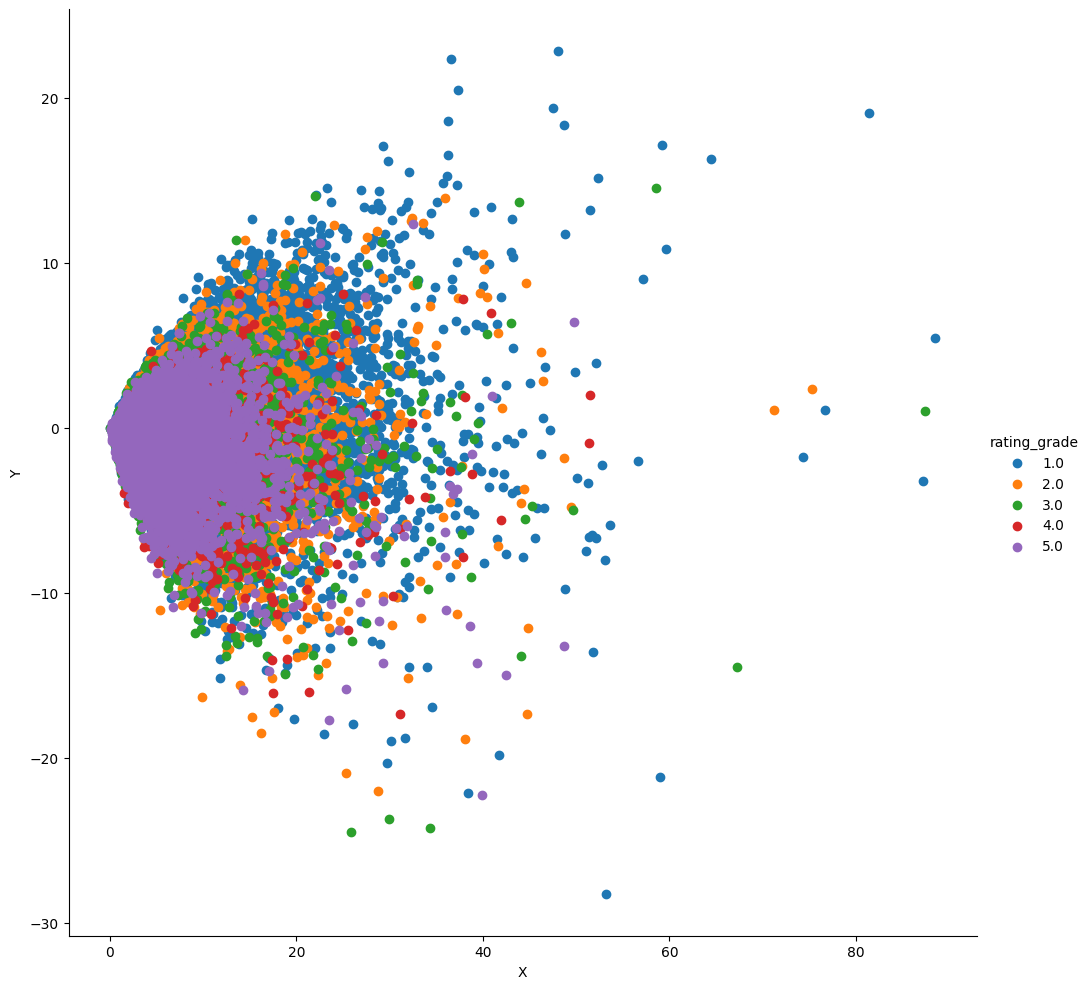

In [26]:
plt.figure(figsize=(14, 14))

# Создайте FacetGrid
g = sns.FacetGrid(vis_df, hue="rating_grade", height=10)
g.map(plt.scatter, "X", "Y").add_legend()

# Отобразите график
plt.show()

Выводы: 

* Во многих темах фигурирует Сбербанк и Qiwi 
* Интерпритация тем: например, тема с индексом 19 - тема о конвертации валют

## Классификация текстов

In [32]:
from sklearn.model_selection import train_test_split

In [68]:
data = pd.concat([
    positive_reviews[["cleaned_text", "rating_grade"]], 
    negative_reviews[["cleaned_text", "rating_grade"]]
])

data["rating_grade"] = data["rating_grade"].replace(5, 0)

In [69]:
data["cleaned_text"] = data["cleaned_text"].replace(".", " ")

In [70]:
X = data["cleaned_text"]
Y = data["rating_grade"]

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, stratify=Y, test_size=0.2)

In [71]:
assert len(x_train) + len(x_test) == len(X)

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('tfidf', TfidfVectorizer()),
    ('lsi', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])


In [86]:
from sklearn.model_selection import RandomizedSearchCV


param_grid = {
  'tfidf__max_df': [0.7, 0.85, 1.0], # Максимальная доля документов для слова
  'tfidf__min_df': [1, 2, 3], # Минимальное количество документов для слова
  'tfidf__ngram_range': [(1, 1), (1, 2), (1, 2, 3)], # Униграммы и биграммы
  'lsi__n_components': [5, 10, 15], # Количество латентных семантических индексов
  'clf__n_estimators': [100, 200], # Количество деревьев в RandomForest
}

# GridSearchCV
randomized_search = RandomizedSearchCV(clf, param_grid, cv=3, n_jobs=-1, verbose=2, n_iter=40, random_state=42)
randomized_search.fit(x_train, y_train)

# Лучшие параметры
print("Лучшие параметры:", randomized_search.best_params_)
# Лучшая оценка
print("Лучшая оценка:", randomized_search.best_score_)
# Лучшая модель
best_clf = randomized_search.best_estimator_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


c:\Users\Руслан\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
27 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Руслан\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Руслан\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Руслан\A

Лучшие параметры: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 3, 'tfidf__max_df': 0.85, 'lsi__n_components': 15, 'clf__n_estimators': 200}
Лучшая оценка: 0.9142512077294686


In [87]:
best_clf.fit(x_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.85, min_df=3, ngram_range=(1, 2))),
                ('lsi', TruncatedSVD(n_components=15)),
                ('clf', RandomForestClassifier(n_estimators=200))])

In [88]:
y_pred = best_clf.predict(x_test)

In [89]:
from sklearn.metrics import classification_report


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.74      0.82      2943
         1.0       0.92      0.98      0.95      9477

    accuracy                           0.92     12420
   macro avg       0.92      0.86      0.88     12420
weighted avg       0.92      0.92      0.92     12420

